In [6]:
import numpy as np 
import os
import cv2
import h5py

import keras.backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import backend as keras

import matplotlib.pyplot as plt

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [7]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou


def unet(input_size = (256, 256, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                                               kernel_initializer = 'he_normal'
                                               )(inputs)
    
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                                               kernel_initializer = 'he_normal'
                                               )(conv1)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(pool1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(pool2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv3)
    
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(pool3)
    
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', 
                                                kernel_initializer = 'he_normal'
                                                )(conv4)
    
    drop4 = Dropout(0.5)(conv4)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', 
                                                 kernel_initializer = 'he_normal'
                                                 )(pool4)
    
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', 
                                                 kernel_initializer = 'he_normal'
                                                 )(conv5)
    
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', 
                                              kernel_initializer = 'he_normal'
                                              )(UpSampling2D(size = (2,2))(drop5))
    
    merge6 = concatenate([drop4,up6])
    
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(merge6)
    
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(UpSampling2D(size = (2,2))(conv6))
    
    merge7 = concatenate([conv3,up7])
    
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(merge7)
    
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal'
                                                )(conv7)

    
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(UpSampling2D(size = (2,2))(conv7))
    
    merge8 = concatenate([conv2,up8])
    
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(merge8)
    
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same',
                                             kernel_initializer = 'he_normal'
                                             )(UpSampling2D(size = (2,2))(conv8))
    
    merge9 = concatenate([conv1,up9])
    
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',
                                               kernel_initializer = 'he_normal'
                                               )(merge9)
    
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',
                                               kernel_initializer = 'he_normal'
                                               )(conv9)
    
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(conv9)
    
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(learning_rate = 1e-3), loss = 'binary_crossentropy', metrics = [dice_coef, iou_coef])

    
    return model

In [4]:
# !cp /content/drive/MyDrive/U-Net-Satellite/Datasets/Dataset_train.h5 /content
# !cp /content/drive/MyDrive/U-Net-Satellite/Datasets/Dataset_test.h5 /content

In [33]:
from PIL import Image
im = Image.fromarray(img_train[0])
im.save("img_train.jpeg")

im = Image.fromarray(mask_train[0])
im.save("mask_train.jpeg")
img_train[0].shape

TypeError: Cannot handle this data type: (1, 1, 1), |u1

In [61]:
print('*'*30)
print('Loading and preprocessing train data...')
print('*'*30)
file = h5py.File(r'C:\Users\SkyMap\Downloads\Dataset_train.h5', 'r')
img_train = file.get('images')
mask_train = file.get('masks')
img_train = np.array(img_train)
mask_train = np.array(mask_train)

i = 0
for m in img_train:
    from PIL import Image
    im = Image.fromarray(img_train[i])
    print(im)
    im.save(f"dataset/a{str(i)}_img_train.jpeg")
    im = Image.fromarray(mask_train[i][:,:,-1])
    im.save(f"dataset/a{str(i)}_mask_train.png")
    i += 1




# img_train = img_train.astype('float32')
# img_train /= 255

# mask_train = mask_train.astype('float32')
# mask_train /= 255  # scale masks to [0, 1]

# print('*'*30)
# print('Creating and compiling model...')
# print('*'*30)
# model = unet()

******************************
Loading and preprocessing train data...
******************************
<PIL.Image.Image image mode=RGB size=256x256 at 0x2452E2E3B38>


FileNotFoundError: [Errno 2] No such file or directory: 'dataset/0_img_train.jpeg'

In [53]:
img_train = np.array(img_train)
mask_train = np.array(mask_train)
mask_train[0][:,:,-1].shape

from PIL import Image
im = Image.fromarray(img_train[0])
print(im)
im.save("img_train.jpeg")
im = Image.fromarray(mask_train[0][:,:,-1])
im.save("mask_train.png")


<PIL.Image.Image image mode=RGB size=256x256 at 0x2452E32BF60>


In [9]:
model.summary()a

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [11]:
print('*'*30)
print('Fitting model...')
print('*'*30)

epochs = 100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint(f'weights_bceloss_{epochs}epochs.h5', monitor='val_loss', save_best_only=True)

history =  model.fit(img_train, mask_train, batch_size=10, epochs=epochs, verbose=1, shuffle=True,
          validation_split=0.2,
          callbacks=[model_checkpoint, early_stopping])

******************************
Fitting model...
******************************
Train on 1669 samples, validate on 418 samples
Epoch 1/100
1669/1669 [==============================] - 134s 80ms/step - loss: 6.8867 - dice_coef: 0.1948 - iou_coef: 0.1007 - val_loss: 0.2551 - val_dice_coef: 0.2436 - val_iou_coef: 0.1160
Epoch 2/100
1669/1669 [==============================] - 132s 79ms/step - loss: 0.2453 - dice_coef: 0.3250 - iou_coef: 0.1772 - val_loss: 0.2181 - val_dice_coef: 0.3124 - val_iou_coef: 0.1585
Epoch 3/100
1669/1669 [==============================] - 132s 79ms/step - loss: 0.2144 - dice_coef: 0.3851 - iou_coef: 0.2191 - val_loss: 0.2000 - val_dice_coef: 0.3866 - val_iou_coef: 0.2143
Epoch 4/100
1669/1669 [==============================] - 132s 79ms/step - loss: 0.2131 - dice_coef: 0.3965 - iou_coef: 0.2285 - val_loss: 0.1902 - val_dice_coef: 0.3917 - val_iou_coef: 0.2095
Epoch 5/100
1669/1669 [==============================] - 126s 76ms/step - loss: 0.4398 - dice_coef: 0.1998

In [12]:
file = h5py.File(r"C:\Users\SkyMap\Downloads\Dataset_test.h5", 'r')
img_test = file.get('images')
mask_test = file.get('masks')
img_test = np.array(img_test)
mask_test = np.array(mask_test)
img_test = img_test.astype('float32')

img_test /= 255

print('*'*30)
print('Loading saved weights...')
print('*'*30)
#model.load_weights('weights.h5')

print('*'*30)
print('Predicting masks on test data...')
print('*'*30)
mask_pred = model.predict(img_test, verbose=1)

******************************
Loading saved weights...
******************************
******************************
Predicting masks on test data...
******************************
20/20 [==============================] - 4s 187ms/step


In [13]:
print('*' * 30)
print('Saving predicted masks to files...')
print('*' * 30)
pred_dir = 'Preds2'
if not os.path.exists(pred_dir):
    os.mkdir(pred_dir)
for i, image in enumerate(mask_test):
    image = (image * 255).astype(np.uint8)
    cv2.imwrite(os.path.join(pred_dir, str(i + 1) + '_pred.png'), image)

******************************
Saving predicted masks to files...
******************************


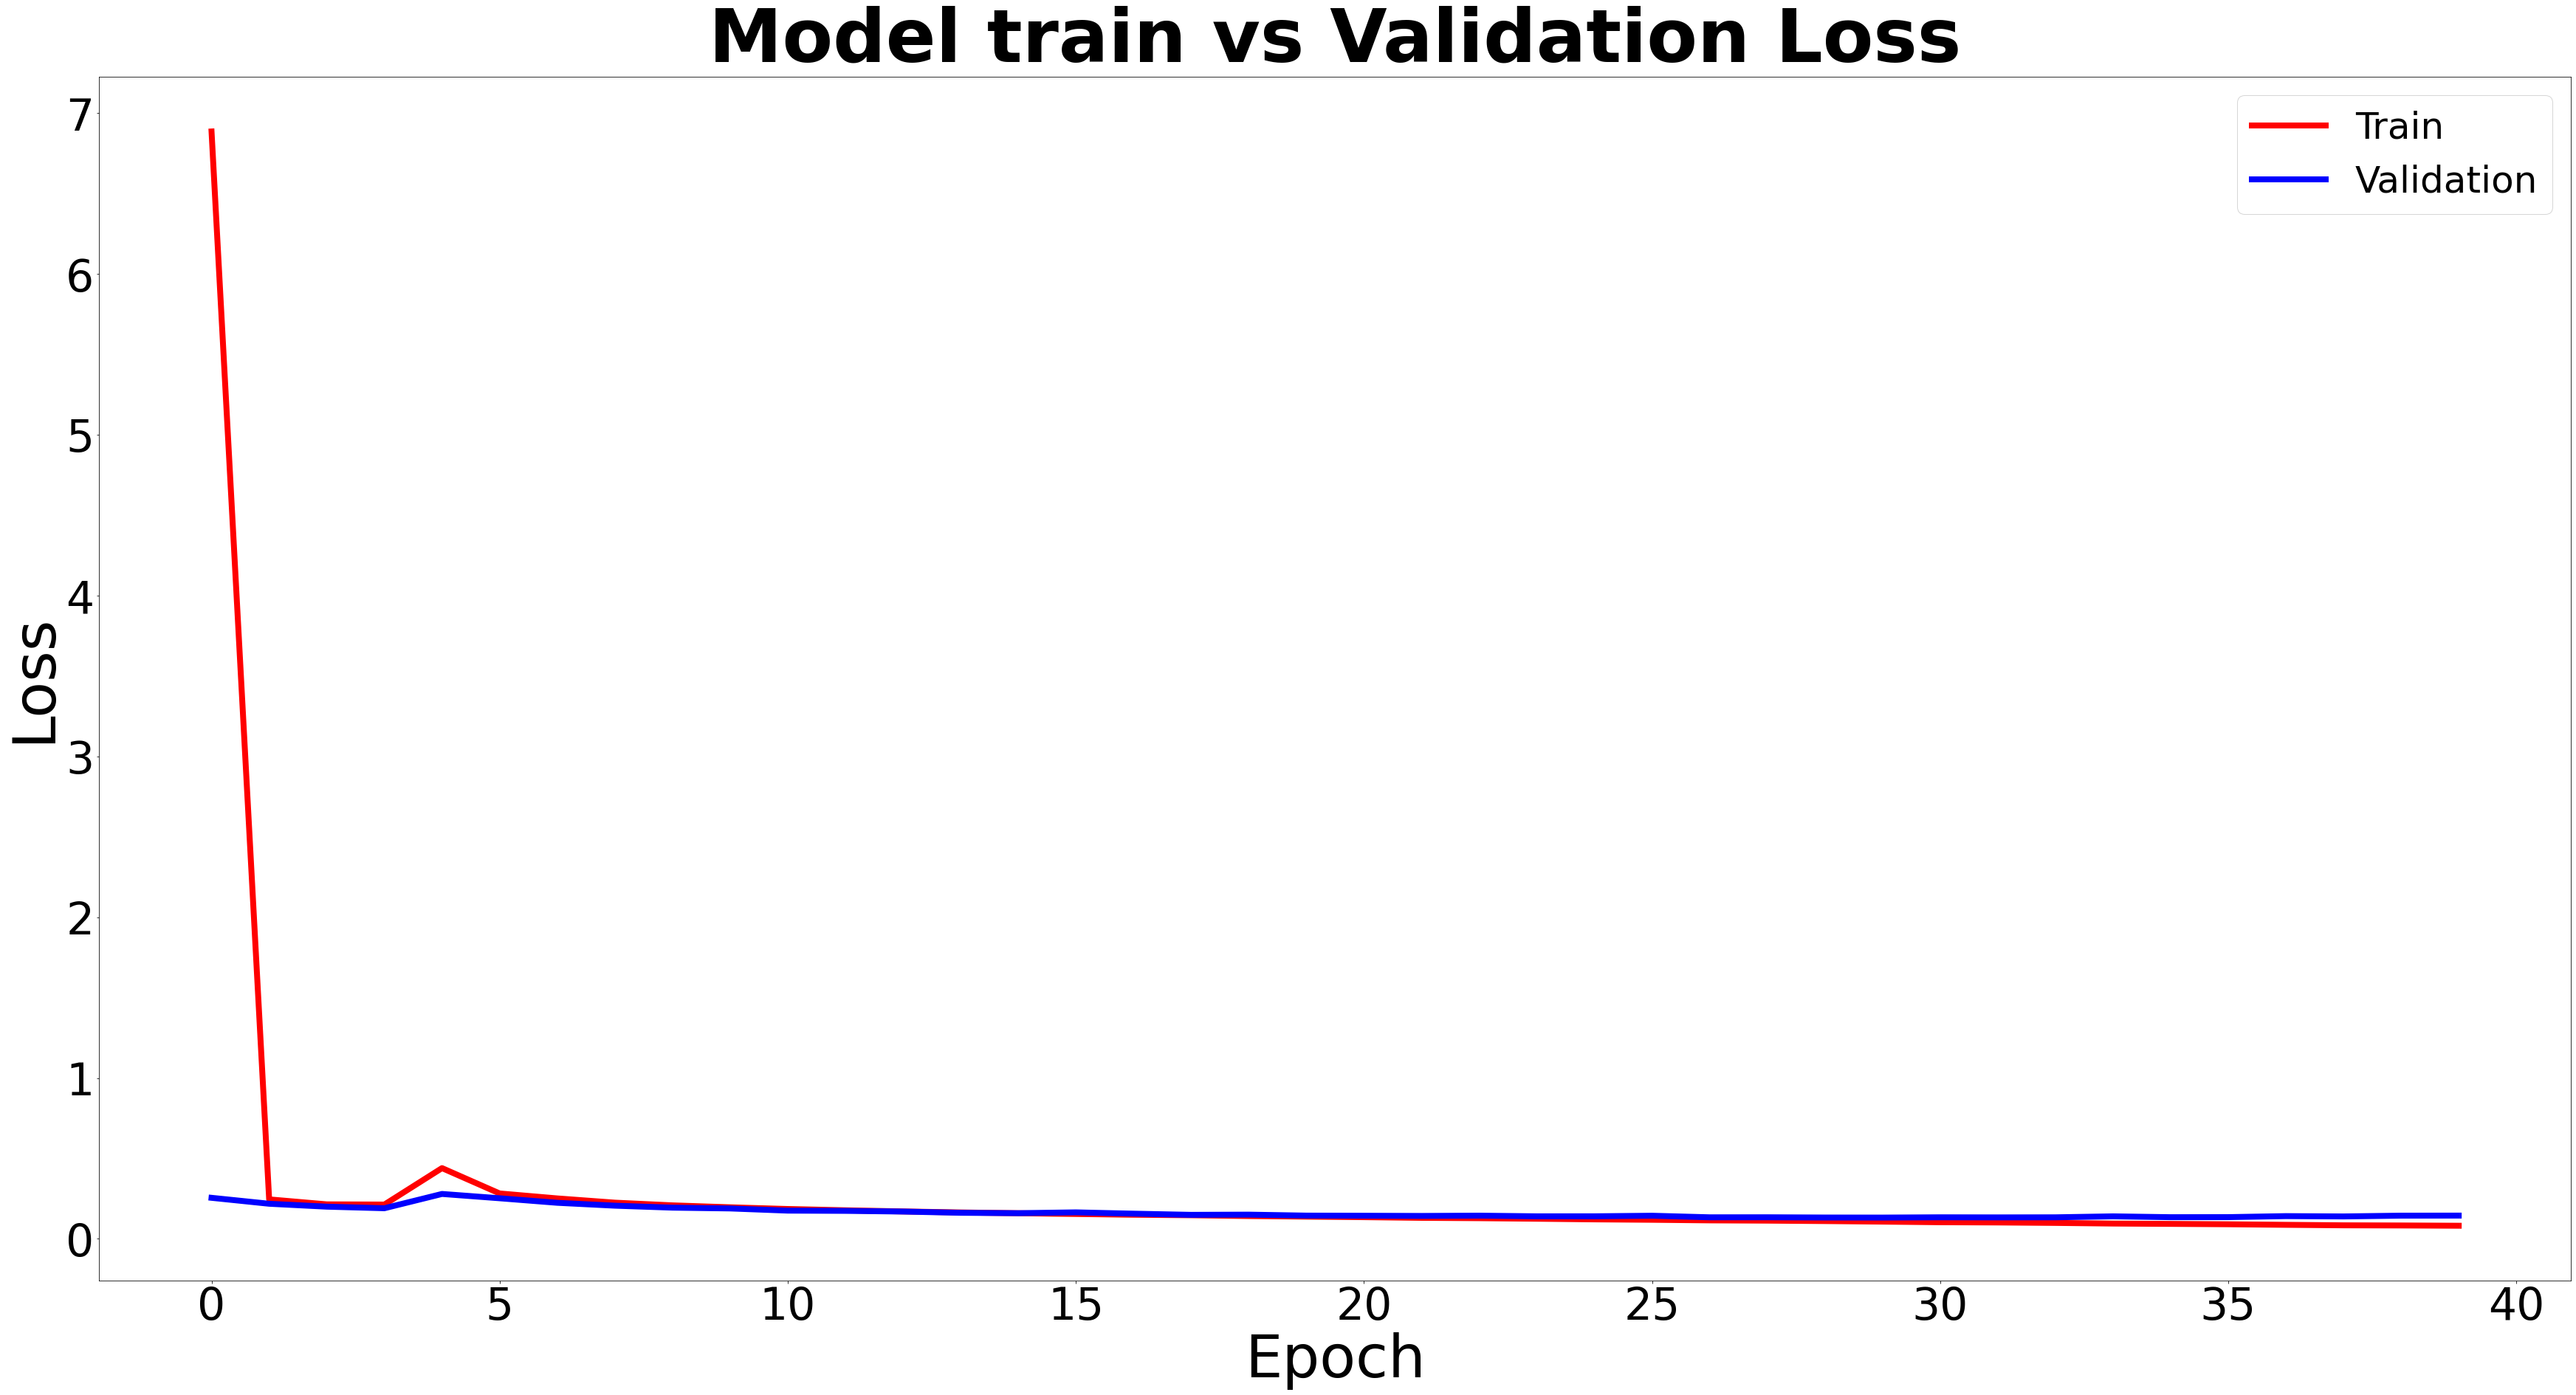

In [14]:
plt.figure(figsize=(60, 30))
plt.plot(history.history['loss'], linewidth=8, color='r')                   #visualising training and validation loss curves
plt.plot(history.history['val_loss'], linewidth=8, color='b')
plt.title('Model train vs Validation Loss', fontsize=100, fontweight="bold")
plt.ylabel('Loss', fontsize=80)
plt.xlabel('Epoch', fontsize=80)
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=50)
plt.xticks(fontsize=60)
plt.yticks(fontsize=60)
plt.show()